In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics


import string
from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [3]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')

In [4]:
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']

In [5]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.columns

Index(['label', 'message'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [10]:
df['label_num'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
df['message_len'] = df.message.apply(len)
df.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

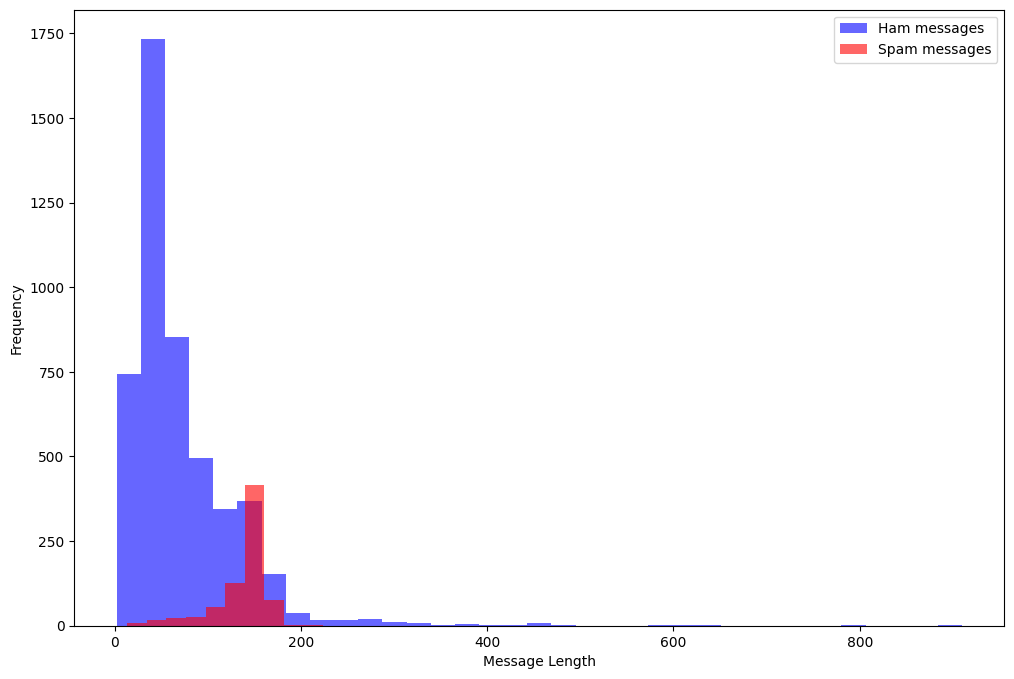

In [12]:
plt.figure(figsize=(12, 8))

df[df.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [13]:
df[df.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [14]:
df[df.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


In [15]:
df[df.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [16]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    #punctuation checking
    nopunc = [char for char in mess if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    # Removing Stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [17]:
df['clean_msg'] = df.message.apply(text_process)
df.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [18]:
words = df[df.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(70))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94), ('give', 92), ('say', 91), ('already', 89), ('right', 89), ('make', 88), ('ask', 88), ('said', 86), ('really', 85), ('yeah', 85), ('amp', 82), ('tomorrow', 80), ('phone', 80), ('didnt', 79), ('e', 78), ('morning', 77), ('please', 76), ('cos', 76), ('life', 74), ('ive', 73), 

In [19]:
words = df[df.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(70))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29), ('want', 29), ('video', 29), ('po', 29), ('tcs', 29), ('award', 28), ('å£150', 27), ('msg', 27), ('chance', 27), ('entry', 26), ('ringtone', 26), ('orange', 26), ('1st', 26), ('collection', 26), ('network', 25), ('selected', 25), ('know', 25), ('50

In [20]:
X = df.clean_msg
y = df.label_num

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
vect = CountVectorizer()
vect.fit(X_train)

# learning the training data and then converting it into the document term matrix(dtm)
# X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

#examining and verify that correctly transformed or not
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (4179, 7996)
<class 'scipy.sparse._csr.csr_matrix'> (1393, 7996)


In [22]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

In [23]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

CPU times: user 5.09 ms, sys: 10 µs, total: 5.1 ms
Wall time: 5 ms
=======Accuracy Score===========
0.9827709978463748
=======Confision Matrix===========
[[1205    8]
 [  16  164]]


In [24]:
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [25]:
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [26]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.11903975e-02, 3.97831612e-04, 1.06470895e-03, ...,
       1.31939653e-02, 9.99821127e-05, 6.04083365e-06])

In [27]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

In [28]:
pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred))

=======Accuracy Score===========
0.9669777458722182
=======Confision Matrix===========
[[1213    0]
 [  46  134]]


In [29]:
logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

y_pred_class = logreg.predict(X_test_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test, y_pred_prob))

CPU times: user 21 ms, sys: 195 µs, total: 21.2 ms
Wall time: 21.5 ms
=======Accuracy Score===========
0.9842067480258435
=======Confision Matrix===========
[[1213    0]
 [  22  158]]
=======ROC AUC Score===========
0.9835714940001832
